# Berlin-Tegel data

In [1]:
#!pip install pmdarima

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy import stats
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.ar_model import ar_select_order

from sklearn.model_selection import TimeSeriesSplit, cross_val_score
from sklearn.metrics import mean_squared_error

from pmdarima.arima import auto_arima

import warnings
warnings.filterwarnings("ignore")

plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (12,8)

In [2]:
df = pd.read_csv('berlin_data/ECA_blended_custom/data.csv', parse_dates=[1])

Remove unnecessary columns and take data from 1970.

In [3]:
df = df.drop(["SOUID", " Q_TG"], axis=1)
df = df.rename(columns={"    DATE": "date", "   TG": "temp"})
df = df.set_index("date")
df = 0.1 * df.loc["1970-01-01":]

In [4]:
df.head()

,temp
date,
1970-01-01,-13.1
1970-01-02,-4.7
1970-01-03,-1.7
1970-01-04,-4.1
1970-01-05,-3.3


In [5]:
#dfm = pd.DataFrame(df.groupby([df.index.year, df.index.month]).mean())
#d = pd.date_range(start='1/1/1970', end='30/4/2022', freq='M')
#dfm = dfm.set_index(d)
dfm = df.resample("M").mean()    # thank you for that function
dfm

,temp
date,
1970-01-31,-4.216129
1970-02-28,-1.696429
1970-03-31,1.490323
1970-04-30,6.180000
1970-05-31,12.841935
...,...
2021-12-31,2.193548
2022-01-31,3.645161
2022-02-28,5.189286


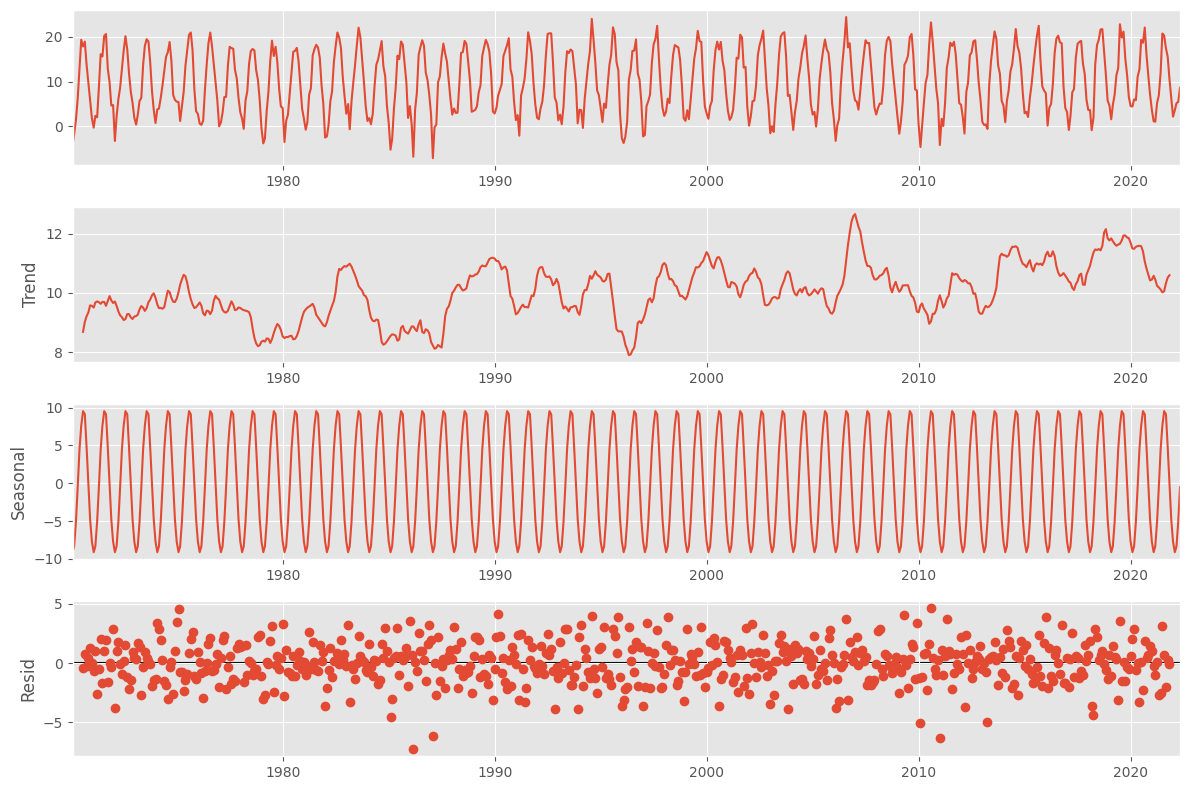

In [8]:
result = seasonal_decompose(dfm, model='additive')
result.plot();

The plot and the adf suggest stationarity. Check the ACF and PACF.

| Model  &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp;| Autocorrelations  &nbsp; &nbsp; &nbsp; &nbsp;| Partial Autocorrelations &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; |
| --- | --- | --- | 
| ARIMA(p,d,0) | Infinite. Tails off. | Finite. Cuts off after p lags. |
| ARIMA(0,d,q) | Finite. Cuts off. | Infinite. Tails off after q lags. |
| ARIMA(p,d,q) | Infinite. Tails off. | Infinite. Tails off. |

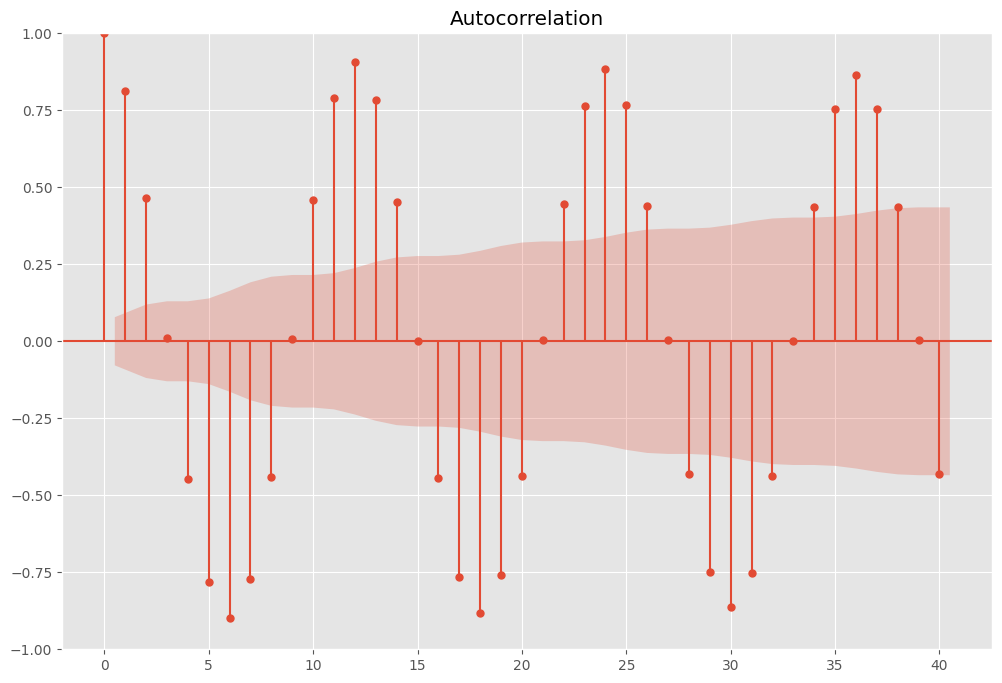

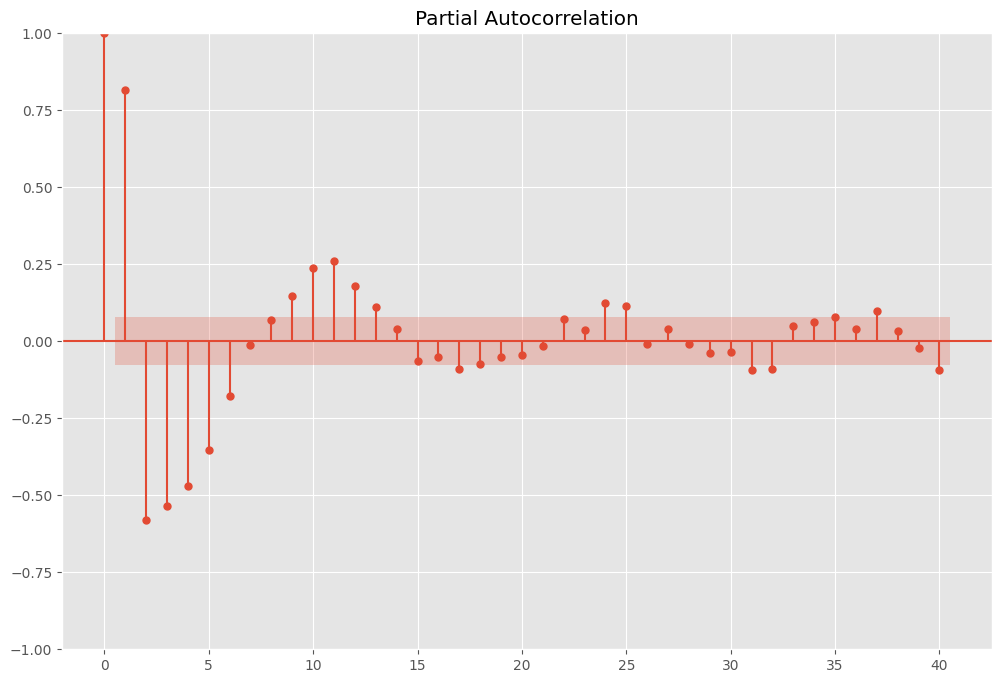

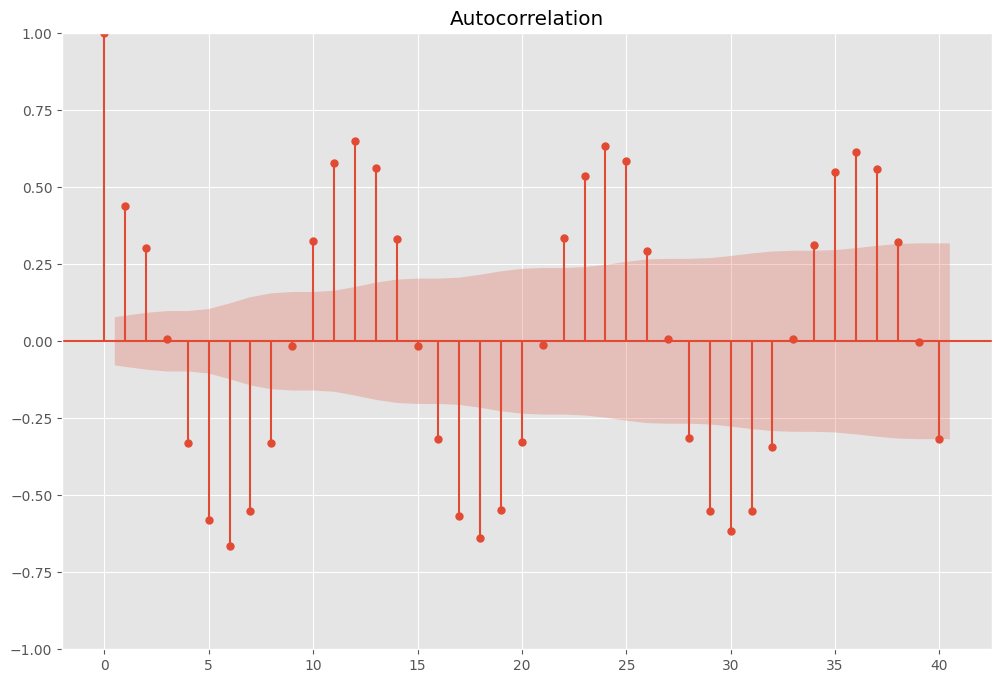

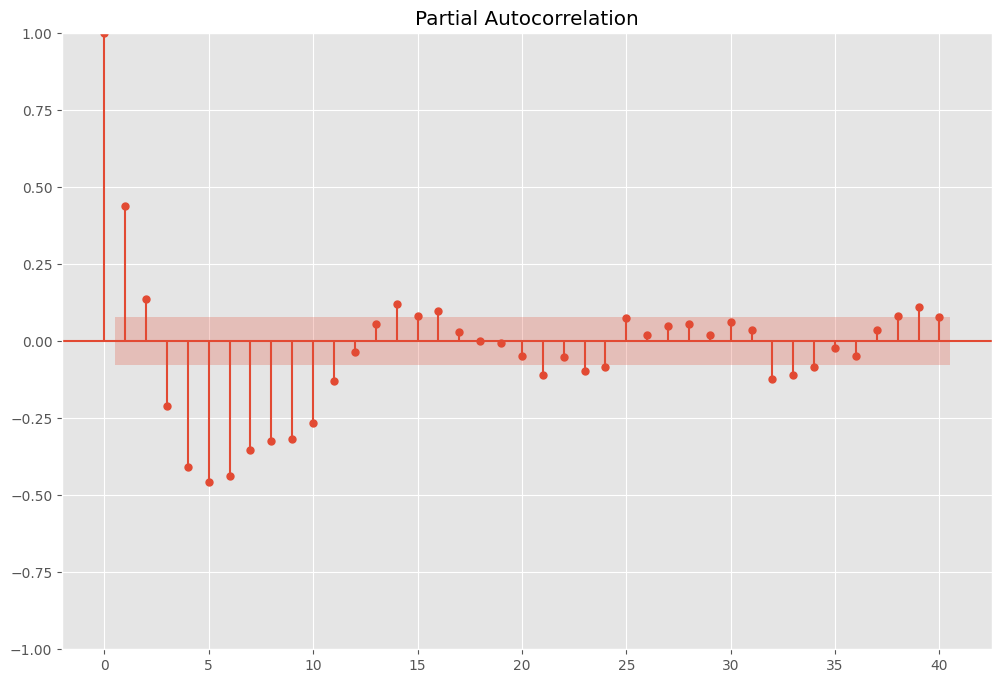

In [9]:
lag = dfm.diff().dropna()

fig = plt.figure()
ax0 = fig.add_subplot()
fig = plot_acf(dfm, lags=40, ax=ax0)
fig = plt.figure(figsize=(12,8))
ax0 = fig.add_subplot()
fig = plot_pacf(dfm, lags=40, ax=ax0)

fig = plt.figure()
ax0 = fig.add_subplot()
fig = plot_acf(lag, lags=40, ax=ax0)
fig = plt.figure(figsize=(12,8))
ax0 = fig.add_subplot()
fig = plot_pacf(lag, lags=40, ax=ax0)

### Identifying the order of differencing and the constant:

All rules are taken from here: https://people.duke.edu/~rnau/arimrule.htm

* Rule 1: If the series has positive autocorrelations out to a high number of lags (say, 10 or more), then it probably needs a higher order of differencing.

In [10]:
selected_order = ar_select_order(dfm, maxlag=20)
print(selected_order.ar_lags)

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]


High number of lags, but the autocorrelation is not always positive $\rightarrow$ No differentiation

#### Therefore $d = 0$.

### Identifying the numbers of AR and MA terms:

* Rule 6: If the partial autocorrelation function (PACF) of the differenced series displays a sharp cutoff and/or the lag-1 autocorrelation is positive--i.e., if the series appears slightly "underdifferenced"--then consider adding one or more AR terms to the model. The lag beyond which the PACF cuts off is the indicated number of AR terms.
* Rule 7: If the autocorrelation function (ACF) of the differenced series displays a sharp cutoff and/or the lag-1 autocorrelation is negative--i.e., if the series appears slightly "overdifferenced"--then consider adding an MA term to the model. The lag beyond which the ACF cuts off is the indicated number of MA terms.
* Rule 8: It is possible for an AR term and an MA term to cancel each other's effects, so if a mixed AR-MA model seems to fit the data, also try a model with one fewer AR term and one fewer MA term--particularly if the parameter estimates in the original model require more than 10 iterations to converge. BEWARE OF USING MULTIPLE AR TERMS AND MULTIPLE MA TERMS IN THE SAME MODEL.
* Rule 9: If there is a unit root in the AR part of the model--i.e., if the sum of the AR coefficients is almost exactly 1--you should reduce the number of AR terms by one and increase the order of differencing by one.
* Rule 10: If there is a unit root in the MA part of the model--i.e., if the sum of the MA coefficients is almost exactly 1--you should reduce the number of MA terms by one and reduce the order of differencing by one.
* Rule 11: If the long-term forecasts* appear erratic or unstable, there may be a unit root in the AR or MA coefficients.

#### Rule 6  $\rightarrow p = 1$ or $2$.

### Identifying the seasonal part of the model:

* Rule 12: If the series has a strong and consistent seasonal pattern, then you must use an order of seasonal differencing (otherwise the model assumes that the seasonal pattern will fade away over time). However, never use more than one order of seasonal differencing or more than 2 orders of total differencing (seasonal+nonseasonal).

#### Therefore $D = 1$.

* Rule 13: If the autocorrelation of the appropriately differenced series is positive at lag s, where s is the number of periods in a season, then consider adding an SAR term to the model. If the autocorrelation of the differenced series is negative at lag s, consider adding an SMA term to the model. The latter situation is likely to occur if a seasonal difference has been used, which should be done if the data has a stable and logical seasonal pattern. The former is likely to occur if a seasonal difference has not been used, which would only be appropriate if the seasonal pattern is not stable over time. You should try to avoid using more than one or two seasonal parameters (SAR+SMA) in the same model, as this is likely to lead to overfitting of the data and/or problems in estimation.

#### Therefore $P = 1$ or $2$.

In [11]:
for p in range(3):
    for P in range(3):
        model = ARIMA(dfm, order=(p,0,0), seasonal_order=(P, 1, 0, 12)).fit()
        print("p = ", p, "   P = ", P, "   BIC = ", model.bic)

p =  0    P =  0    BIC =  2981.05357754376
p =  0    P =  1    BIC =  2836.910403475823
p =  0    P =  2    BIC =  2781.989197224703
p =  1    P =  0    BIC =  2969.5512832115405
p =  1    P =  1    BIC =  2818.322512593456
p =  1    P =  2    BIC =  2763.250845793954
p =  2    P =  0    BIC =  2975.5766900206318
p =  2    P =  1    BIC =  2823.848331702651
p =  2    P =  2    BIC =  2768.983531172041


#### As expected (lol) we get p=1 and P=2.

From https://www.ncss.com/wp-content/themes/ncss/pdf/Procedures/NCSS/The_Box-Jenkins_Method.pdf

## Seasonal Time Series
To deal with series containing seasonal fluctuations, Box-Jenkins recommend the following general model:

$\phi_p(B)\Phi_P(B)(1-B)^d(1-B^s)^DX_t = \theta_q(B) \Theta_Q(B^s)a_t$

where d is the order of differencing, s is the number of seasons per year, and D is the order of seasonal
differencing.

In python we have for der ARIMA model the parameters order = $(p,d,q)$ and seasonal_order = $(P,D,Q,s)$.

### Observation: Above they say the seasonal term MUST have D=1 to have an impact. But from the formula we see that s appears also in Q. Try out with D=0 and Q>0.

In [12]:
for q in range(3):
    for Q in range(3):
        model = ARIMA(dfm, order=(1, 0, q), seasonal_order=(2, 1, Q, 12)).fit()
        print("q = ", q, "   Q = ", Q, "   BIC = ", model.bic)

q =  0    Q =  0    BIC =  2763.250845793954
q =  0    Q =  1    BIC =  2632.931708786011
q =  0    Q =  2    BIC =  2638.094053318893
q =  1    Q =  0    BIC =  2767.102391014653
q =  1    Q =  1    BIC =  2634.3261551318597
q =  1    Q =  2    BIC =  2639.147471849198
q =  2    Q =  0    BIC =  2770.6241290960374
q =  2    Q =  1    BIC =  2632.9827656873813
q =  2    Q =  2    BIC =  2637.734387595977


In [178]:
for q in range(3):
    for Q in range(3):
        model = ARIMA(dfm, order=(1, 0, q), seasonal_order=(2, 0, Q, 12)).fit()
        print("q = ", q, "   Q = ", Q, "   BIC = ", model.bic)

q =  0    Q =  0    BIC =  2895.510165935318
q =  0    Q =  1    BIC =  2714.417242124739
q =  0    Q =  2    BIC =  2720.4317776898365
q =  1    Q =  0    BIC =  2900.025659454015
q =  1    Q =  1    BIC =  2717.1385940524806
q =  1    Q =  2    BIC =  2722.4689298379167
q =  2    Q =  0    BIC =  2906.405782422702
q =  2    Q =  1    BIC =  2719.9079958958887
q =  2    Q =  2    BIC =  2723.7403729692946


In [13]:
model.aic

2602.3484118877086

In [ ]:
auto = auto_arima(dfm, start_p=0, 
                       d=None, 
                       start_q=0, 
                       max_p=6, 
                       max_d=1, 
                       max_q=6, 
                       start_P=0, 
                       D=None, 
                       start_Q=0, 
                       max_P=2, 
                       max_D=1, 
                       max_Q=2, 
                       max_order=24, 
                       m=12, 
                       seasonal=True, 
                       stationary=True, 
                       information_criterion='bic')

In [ ]:
print(auto.summary())

It looked stationary before but since the tails dont cut off. This suggests now a $(p,d,q)$ Model with some seasonality.

## Conclusion: My prediction is better then AUTO_ARIMA?

In [99]:
parameters = []
best = 10000
count = 0
for p in range(7):
    for q in range(3):
        for P in range(3):
            for Q in range(3):
                count += 1
                print(count)
                try:
                    model = ARIMA(dfm, order=(p, 0, q), seasonal_order=(P, D, Q, 12)).fit()
                except:
                    continue
                if model.bic < best:
                    print(count, best)
                    best = model.bic
                    parameters = [p, 0, q, P, D, Q, 12, model.bic]
                    

1
1 10000
2
2 2981.053577543761
3
4
5
6
7
8
9
10
11
11 2648.6292793165435
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
29 2624.553819961544
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
47 2620.8153647681147
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
65 2620.8152413759944
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189


In [271]:
model = ARIMA(dfm, order=(1, 0, 2), seasonal_order=(0, 1, 1, 12)).fit()
model.bic

2620.8152413759944

In [272]:
def plot_normal_dist(model):
    resid = model.resid

    fig = plt.figure(figsize=(12,8))
    ax0 = fig.add_subplot(111)

    sns.distplot(resid ,fit = stats.norm, ax = ax0) # need to import scipy.stats

    # Get the fitted parameters used by the function
    (mu, sigma) = stats.norm.fit(resid)

    #Now plot the distribution using 
    plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)], loc='best')
    plt.ylabel('Frequency')
    plt.title('Residual distribution')

    # ACF and PACF
    fig = plt.figure(figsize=(12,8))
    ax1 = fig.add_subplot(211)
    fig = plot_acf(resid, lags=40, ax=ax1)
    ax2 = fig.add_subplot(212)
    fig = plot_pacf(resid, lags=40, ax=ax2)

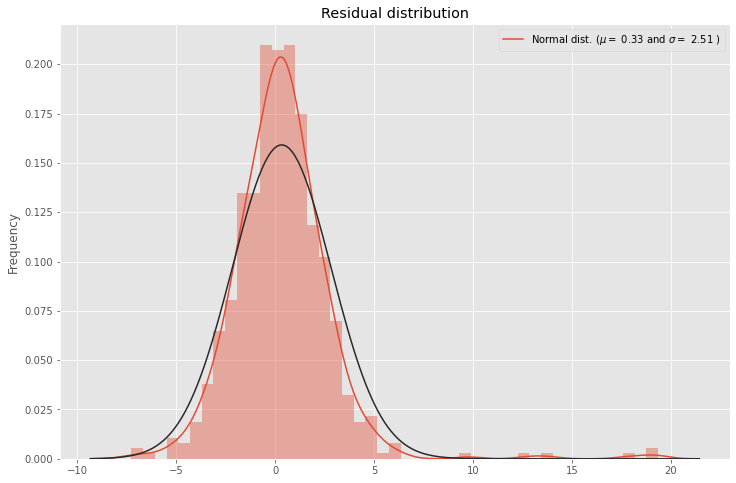

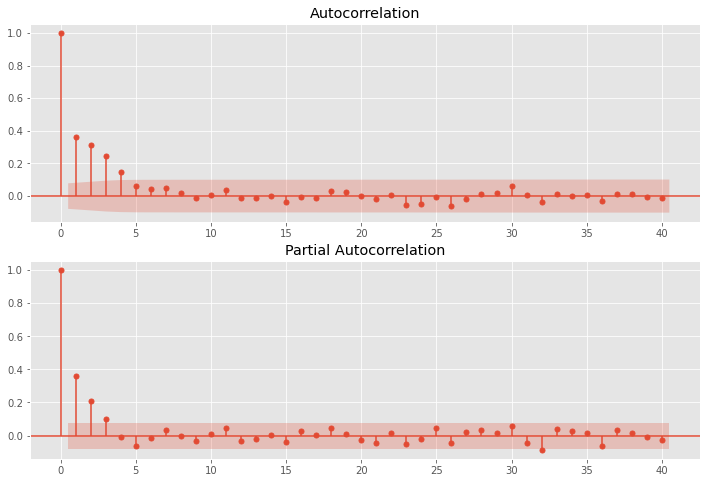

In [273]:
plot_normal_dist(model)

https://iopscience.iop.org/article/10.1088/1757-899X/394/5/052024/pdf

<AxesSubplot:xlabel='date'>

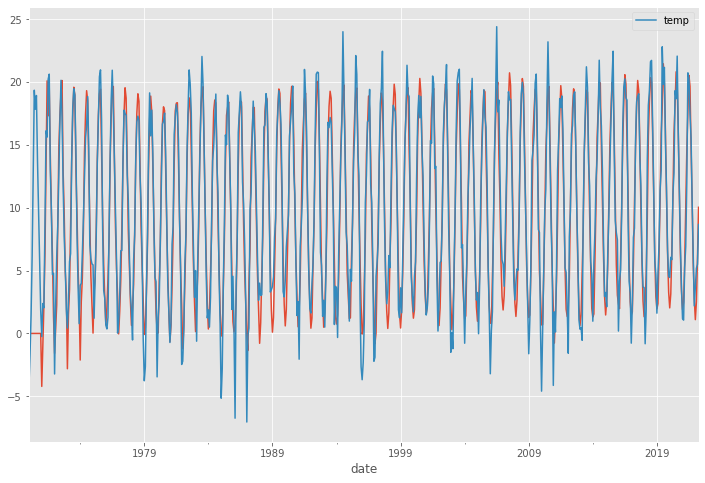

In [274]:
fig = plt.figure()
ax = fig.subplots()
model.predict().plot(ax=ax, label="predicted")
dfm.plot(ax=ax, label="original")


## Validation

In [174]:
ts_split = TimeSeriesSplit(n_splits=5)
rmse = []

In [276]:
for train_index, test_index in ts_split.split(dfm):
    cv_train, cv_test = dfm.iloc[train_index], dfm.iloc[test_index]
    
    cv_model = ARIMA(cv_train, order=(1, 0, 2), seasonal_order=(0, 1, 1, 12)).fit()
    
    pred = cv_model.predict(cv_test.index.values[0], cv_test.index.values[-1])
    true_values = cv_test.values
    rmse.append(np.sqrt(mean_squared_error(true_values, pred)))

print(rmse)
print(np.mean(rmse))

[2.260331886443631, 2.439250522955225, 1.9536800241658352, 2.1059202906084726, 2.126407869330475, 2.260331886443631, 2.439250522955225, 1.9536800241658352, 2.1059202906084726, 2.126407869330475]
2.1771181187007276


In [176]:
np.sqrt(np.mean(model.resid**2))

2.5289401829220415

## Forecasting

In [277]:
dfm.iloc[-1]

temp    8.666667
Name: 2022-04-30 00:00:00, dtype: float64

In [225]:
df

,temp
date,
1970-01-01,-13.1
1970-01-02,-4.7
1970-01-03,-1.7
1970-01-04,-4.1
1970-01-05,-3.3
...,...
2022-04-26,11.0
2022-04-27,11.9
2022-04-28,10.8


In [282]:
# Forecast
fc = model.forecast(80, alpha=0.05).to_frame()  # 95% conf
fc = fc.rename(columns={"predicted_mean":"temp"})

dfmf = dfm.copy()
dfmf = dfmf.append(fc)

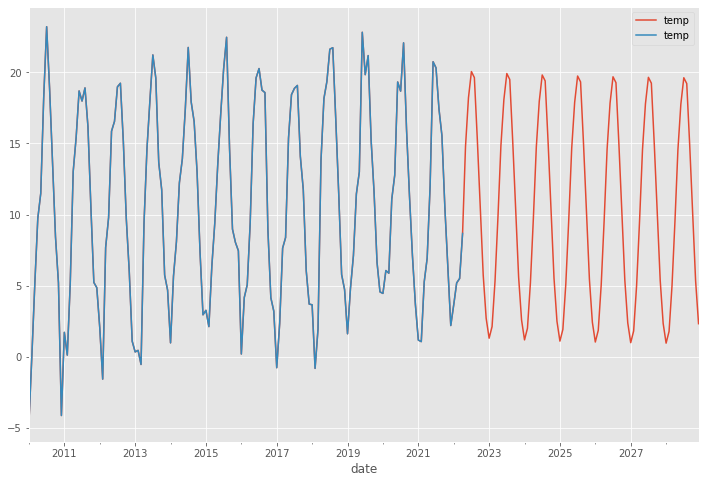

In [283]:
fig = plt.figure()
ax = plt.subplot()
dfmf.loc["2010-01-01":].plot(ax = ax)
dfm.loc["2010-01-01":].plot(ax = ax)
plt.legend()